# Problem Statement

With environmental issues and health becoming trending topics, usage of bicycles as a mode of
transportation has gained traction in recent years. To encourage bike usage, cities across the world have
successfully rolled out bike sharing programs. Under such schemes, riders can rent bicycles using manual/
automated kiosks spread across the city for defined periods. In most cases, riders can pick up bikes from one
location and return them to any other designated place.

The bike sharing platforms from across the world are hotspots of all sorts of data, ranging from travel
time, start and end location, demographics of riders, and so on. This data along with alternate sources
of information such as weather, traffic, terrain, and so on makes it an attractive proposition for different
research areas.

The Capital Bike Sharing dataset contains information related to one such bike sharing program
underway in Washington DC. Given this augmented (bike sharing details along with weather information)
dataset, can we forecast bike rental demand for this program?

In [69]:
# load data
import pandas as pd
import numpy as np

hour_df = pd.read_csv('hour.csv')
print("Shape of dataset::{}".format(hour_df.shape))

Shape of dataset::(17379, 17)


The dataset contains more than 17k records with 17 attributes.

In [70]:
# check the first few
hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [71]:
# check the datatypes
hour_df.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [72]:
# rename columns
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

In [73]:
# typecasting to datetime
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)
# categorical variables
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

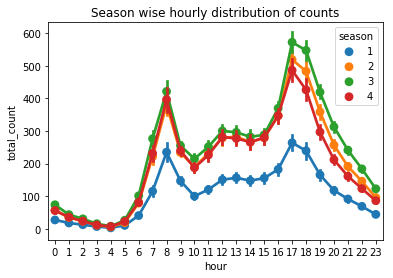

In [74]:
# visualizing hourly ridership counts across the seasons.
# plotting
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
sn.pointplot(data=hour_df[['hour',
                           'total_count',
                           'season']],
             x='hour',y='total_count',
             hue='season',ax=ax)
ax.set(title="Season wise hourly distribution of counts")

[Text(0.5, 1.0, 'Monthly distribution of counts')]

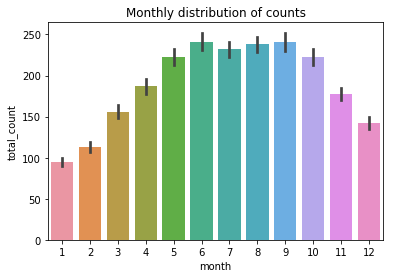

In [75]:
# visualize monthly ridership trends
fig,ax = plt.subplots()
sn.barplot(data=hour_df[['month',
                         'total_count']],
           x="month",y="total_count")
ax.set(title="Monthly distribution of counts")

[Text(0.5, 1.0, 'Yearly distribution of counts for both 2011 and 2012')]

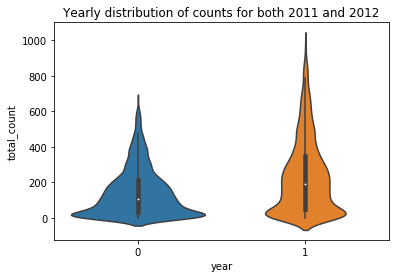

In [76]:
fig,ax = plt.subplots()
sn.violinplot(data=hour_df[['year',
                         'total_count']],
           x="year",y="total_count")
ax.set(title="Yearly distribution of counts for both 2011 and 2012")

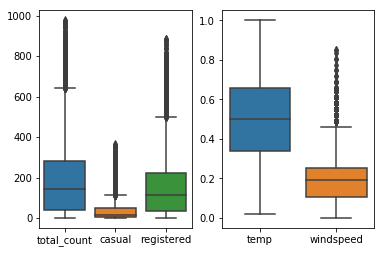

In [77]:
# check for outliers in the data
fig,(ax1,ax2)= plt.subplots(ncols=2)
sn.boxplot(data=hour_df[['total_count',
                         'casual','registered']],ax=ax1)
sn.boxplot(data=hour_df[['temp','windspeed']],ax=ax2)

[Text(0.5, 1.0, 'holiday')]

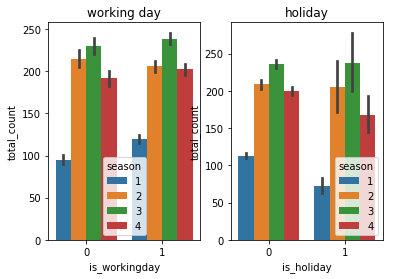

In [78]:
# Working Day Vs Holiday Distribution
fig,(ax1,ax2) = plt.subplots(ncols=2)
sn.barplot(data=hour_df,x='is_workingday',y='total_count',hue='season',ax = ax1)
sn.barplot(data=hour_df,x='is_holiday',y='total_count',hue='season',ax = ax2)

ax1.set(title="working day")
ax2.set(title="holiday")

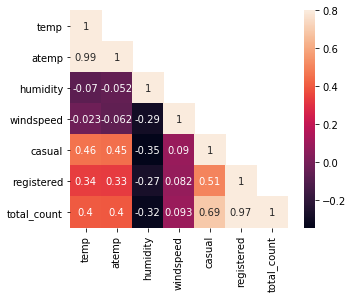

In [79]:
# correlation matrix
corrMatt = hour_df[["temp","atemp",
                    "humidity","windspeed",
                    "casual","registered",
                    "total_count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
sn.heatmap(corrMatt, mask=mask,
           vmax=.8, square=True,annot=True)

## Regression Analysis
Regression analysis is a statistical modeling technique used by statisticians and Data Scientists alike. It is
the process of investigating relationships between dependent and independent variables. Regression itself
includes a variety of techniques for modeling and analyzing relationships between variables. It is widely
used for predictive analysis, forecasting, and time series analysis.

In [80]:
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
        column.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded

    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series

    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

In [81]:
# divide the dataset at hand into training and testing sets to evaluate the performance of our models
# modeling utilities
import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3],
                                       hour_df.iloc[:,-1],
                                       test_size=0.33,
                                       random_state=42)

X.reset_index(inplace=True)
y=y.reset_index()

X_test.reset_index(inplace=True)
y_test=y_test.reset_index()


In [82]:
# loops through the list of categorical variables
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

/home/grace/.local/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/grace/.local/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In cas

In [83]:
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


In [84]:
# Linear regression
X = train_df_new
y= y.total_count.values.reshape(-1,1)

lin_reg = linear_model.LinearRegression()

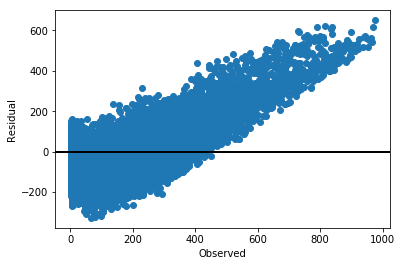

In [85]:
predicted = cross_val_predict(lin_reg, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, y-predicted)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

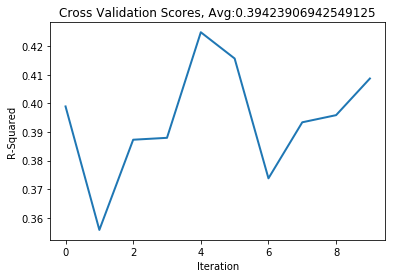

In [86]:
r2_scores = cross_val_score(lin_reg, X, y, cv=10)
mse_scores = cross_val_score(lin_reg, X, y, cv=10,scoring='neg_mean_squared_error')
fig, ax = plt.subplots()
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [89]:
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [92]:

test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,
                                                              le,ohe,
                                                              col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))


KeyError: 'season'

In [94]:
test_df_new.head()


,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.80,0.27,0.1940,19,6,6,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.24,0.41,0.2239,20,1,1,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.32,0.66,0.2836,2,5,10,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.78,0.52,0.3582,19,2,5,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.26,0.56,0.3881,0,4,1,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [96]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

y_pred = lin_reg.predict(X_test)

residuals = y_test-y_pred


AttributeError: 'numpy.ndarray' object has no attribute 'total_count'

In [97]:

r2_score = lin_reg.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.402440968267343


NameError: name 'y_pred' is not defined